# import libraries

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Subset

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torchvision
import torchvision.transforms as T
from torchsummary import summary

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_8544\1963766096.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# import cifar10 dataset and split train/devol/test

In [4]:
transform = T.Compose([T.ToTensor(),
#                        T.RandomRotation(30),
                      T.Normalize([.5,.5,.5],[.5,.5,.5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=False, transform=transform)

devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

category=devtest.classes

randidx=np.random.permutation(10000)
devset=Subset(devtest,randidx[:6000])
testset=Subset(devtest,randidx[6000:])

train_loader=DataLoader(trainset,batch_size=64,shuffle=True,drop_last=True)
dev_loader=DataLoader(devset,batch_size=64)
test_loader=DataLoader(testset,batch_size=len(testset))

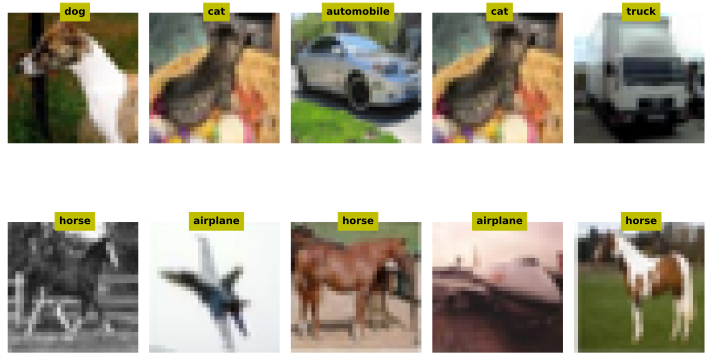

In [5]:
dat,lab=next(iter(train_loader))

fig,axs=plt.subplots(2,5,figsize=(10,7))

for ax in axs.flatten():
    index=np.random.randint(dat.data.shape[0])
    pic=dat.data[index].permute(1,2,0)
    pic = pic/2 + .5
    label=category[lab[index]]
    ax.imshow(pic)
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')
    
plt.tight_layout()
plt.show()    

# cnn model

In [6]:
def createModel(printSize=False):
    class Model(nn.Module):
        def __init__(self,printSize):
            super().__init__()
            inChan=3
            firstChan=15
            secChan=30
            thirChan=60
            # incoder
            self.enConv1=nn.Conv2d(inChan,firstChan,3,1,1)
            self.enConv2=nn.Conv2d(firstChan,secChan,3,1,1)
            
            # latent
            self.latent=nn.Conv2d(secChan,thirChan,3,1,1)
            
            # decoder
            self.decod1=nn.ConvTranspose2d(thirChan,secChan,2,2,0)
            self.decod2=nn.ConvTranspose2d(secChan,firstChan,2,2,0)
            self.decod3=nn.ConvTranspose2d(firstChan,inChan,2,2,0)
            
            self.print=printSize
        def forward(self,x):
            if self.print: print(f'input : {list(x.shape)}')
                
            x=F.max_pool2d(self.enConv1(x),3,2,1)
            if self.print: print(f'first encod layer: {list(x.shape)}' )
            
            x=F.max_pool2d(self.enConv2(x),3,2,1)
            if self.print: print(f'second encod layer: {list(x.shape)}' )
            
            x=F.max_pool2d(self.latent(x),3,2,1)
            if self.print: print(f'latent layer: {list(x.shape)}' )
                
            x=self.decod1(x)
            if self.print: print(f'first decod layer: {list(x.shape)}' )
                
            x=self.decod2(x)
            if self.print: print(f'second decod layer: {list(x.shape)}' )
                
            x=self.decod3(x)
            if self.print: print(f'third decod layer: {list(x.shape)}' )
            return x
        
    cnn=Model(printSize)
    lossfun=nn.MSELoss()
    optimizer=torch.optim.Adam(cnn.parameters(),lr=.001)
    return cnn,lossfun,optimizer             

input : [64, 3, 32, 32]
first encod layer: [64, 15, 16, 16]
second encod layer: [64, 30, 8, 8]
latent layer: [64, 60, 4, 4]
first decod layer: [64, 30, 8, 8]
second decod layer: [64, 15, 16, 16]
third decod layer: [64, 3, 32, 32]


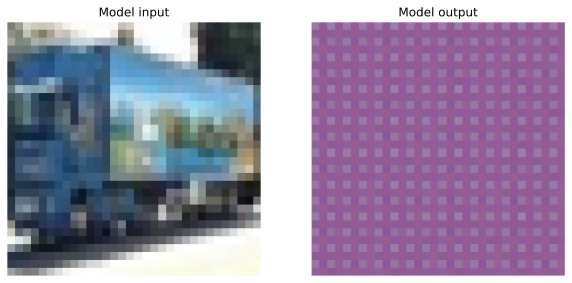

In [7]:
cnn,lossfun,optimizer=createModel(True)
dat,lab=next(iter(dev_loader))
yHat=cnn(dat)

fig,ax=plt.subplots(1,2,figsize=(10,7))
org=torch.squeeze(dat[10,:,:,:]).detach().permute(1,2,0)/2 +.5
pred=torch.squeeze(yHat[10,:,:,:]).detach().permute(1,2,0)/2 +.5
ax[0].imshow(org)
ax[0].set_title('Model input')
ax[1].imshow(pred)
ax[1].set_title('Model output')
for i in range(2):ax[i].axis('off')
plt.show()

In [8]:
summary(cnn,(3,32,32))

input : [2, 3, 32, 32]
first encod layer: [2, 15, 16, 16]
second encod layer: [2, 30, 8, 8]
latent layer: [2, 60, 4, 4]
first decod layer: [2, 30, 8, 8]
second decod layer: [2, 15, 16, 16]
third decod layer: [2, 3, 32, 32]
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 15, 32, 32]          420
├─Conv2d: 1-2                            [-1, 30, 16, 16]          4,080
├─Conv2d: 1-3                            [-1, 60, 8, 8]            16,260
├─ConvTranspose2d: 1-4                   [-1, 30, 8, 8]            7,230
├─ConvTranspose2d: 1-5                   [-1, 15, 16, 16]          1,815
├─ConvTranspose2d: 1-6                   [-1, 3, 32, 32]           183
Total params: 29,988
Trainable params: 29,988
Non-trainable params: 0
Total mult-adds (M): 3.59
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.11
Estimated Total Size (MB): 0.40


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 15, 32, 32]          420
├─Conv2d: 1-2                            [-1, 30, 16, 16]          4,080
├─Conv2d: 1-3                            [-1, 60, 8, 8]            16,260
├─ConvTranspose2d: 1-4                   [-1, 30, 8, 8]            7,230
├─ConvTranspose2d: 1-5                   [-1, 15, 16, 16]          1,815
├─ConvTranspose2d: 1-6                   [-1, 3, 32, 32]           183
Total params: 29,988
Trainable params: 29,988
Non-trainable params: 0
Total mult-adds (M): 3.59
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.11
Estimated Total Size (MB): 0.40

# model training

In [9]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [10]:
def trainModel(Numepoch=10):
    cnn,lossfun,optimizer = createModel(False)
    
    trainLoss=torch.zeros(Numepoch)
    devolLoss=torch.zeros(Numepoch)
    cnn.to(device)
    
    nWeights=0
    for pname,weight in cnn.named_parameters():
        if 'bias' not in pname:
            nWeights=nWeights+weight.numel()
    
    for epoch in range(Numepoch):
        batchLoss=[]
        cnn.train()
        
        for dat,lab in train_loader:
            dat=dat.to(device)
            
            yHat=cnn(dat)
            loss=lossfun(yHat,dat)
            
            #l1 reguluzation
            L1_term=torch.tensor(0.,requires_grad=True)
            for pname,weight in cnn.named_parameters():
                if 'bias' not in pname:
                    L1_term=L1_term + torch.sum(torch.abs(weight))
            
            loss=loss+ 0.001*L1_term/nWeights
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
        
        trainLoss[epoch]=np.mean(batchLoss)
        
        batchLoss=[]
        
        cnn.eval()
        
        for dat,lab in dev_loader:
            dat=dat.to(device)
            
            if torch.no_grad():
                yHat=cnn(dat)
                loss=lossfun(yHat,dat)
                        
            batchLoss.append(loss.item())
            

        devolLoss[epoch]=np.mean(batchLoss)
            
    return  cnn,trainLoss,devolLoss

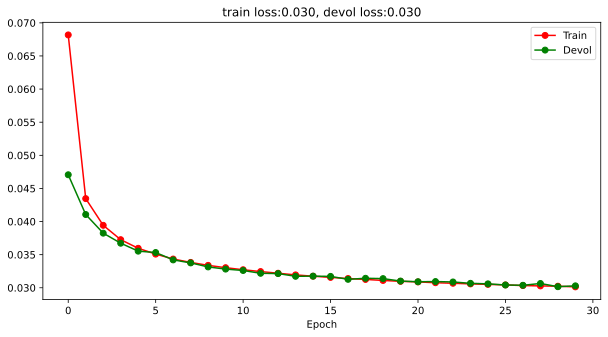

In [11]:
cnn,trainLoss,devolLoss=trainModel(30)
fig,ax=plt.subplots(1,figsize=(10,5))
ax.plot(trainLoss,'ro-',label='Train')
ax.plot(devolLoss,'go-',label='Devol')
ax.set_xlabel('Epoch')
ax.set_title(f'train loss:{trainLoss[-1]:.3f}, devol loss:{devolLoss[-1]:.3f}')
ax.legend()


# model testing

In [18]:
dat,lab=next(iter(test_loader))
dat=dat.to(device)
cnn.to(device)
yHat=cnn(dat)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


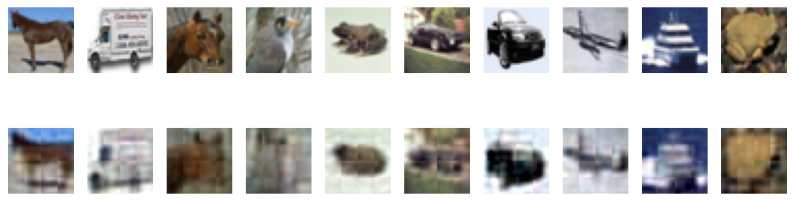

In [21]:
dat=dat.cpu()
yHat=yHat.cpu()

fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
    index=np.random.randint(dat.data.shape[0])
    org=torch.squeeze(dat[index,:,:,:]).detach().permute(1,2,0)
    org=org/2 +.5
    
    pred=torch.squeeze(yHat[index,:,:,:]).detach().permute(1,2,0)
    pred=pred/2 +.5
    
    axs[0,i].imshow(org)
    axs[0,i].axis('off')

    axs[1,i].imshow(pred)
    axs[1,i].axis('off') 
plt.show()